# CNN Model

##### Some basic augmentation

##### With weighing

##### Batch size defined

##### Combined vgg16 with additional layers

##### 600 positive cases

##### 5000 negative cases

##### hyperparameter tuning


## Import Libraries


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import keras.backend as K

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers


import csv
import random
import pickle


## Load downsampled dataset


In [3]:
# Load the compressed array from disk
images_mini_norm = np.load('mandy_github_folder\W207MammogramProject\CNN_Xs_downsample_forvgg16.npz')['data']

In [4]:
# load the labels from disk
with open('mandy_github_folder\W207MammogramProject\CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [5]:
print('images_mini.shape:', images_mini_norm.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


In [6]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 255.0
Confirm min pixel value is 0: 0.0


## Visualize image transformations


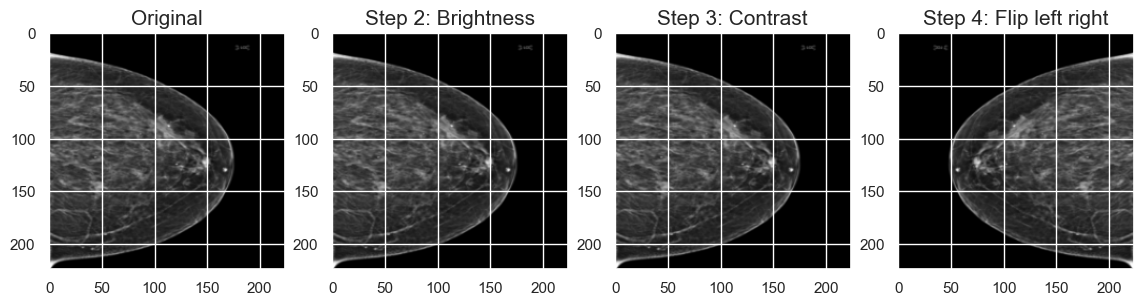

In [7]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini_norm[0]

# plot original
ax = fig.add_subplot(1, 4, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);


# adjust brightness
ax = fig.add_subplot(1, 4, 2)
img_bright = tf.image.adjust_brightness(image, -.8)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 4, 3)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 4, 4)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);


## Split data into train, validate, test


In [8]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; 
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    ### Create train/validation/test sets ###
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images = images[shuffle]
    y = y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini_norm,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"y_train positive cases {sum(y_train)}\n")

print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"y_val positive cases {sum(y_val)}\n")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")
print(f"y_test positive cases {sum(y_test)}\n")

X_train shape (3360, 224, 224, 3)
y_train shape (3360,)
y_train positive cases 371

X_val shape (1120, 224, 224, 3)
y_val shape (1120,)
y_val positive cases 114

X_test shape (1120, 224, 224, 3)
y_test shape (1120,)
y_test positive cases 115



## Augmentation function


In [10]:
def preprocess_augm(X_train, y_train):
    
    # Augment only cancer=1 data
    X_train_w_cancer = X_train[y_train == 1, :, :, :]
    y_train_w_cancer = y_train[y_train == 1]
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm1 = tf.image.adjust_brightness(X_train_w_cancer, delta=.1)
    X_train_augm2 = tf.image.adjust_brightness(X_train_w_cancer, delta=.2)
    
    # adjust contrast
    X_train_augm5 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=1)
    X_train_augm6 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=2)

    # random flip
    X_train_augm8 = tf.image.random_flip_left_right(X_train_w_cancer)
    
    # concatenate augmented X_train data
    X_train_augm = tf.concat([X_train_augm1, X_train_augm2, X_train_augm5,
                        X_train_augm6, X_train_augm8],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = tf.convert_to_tensor(np.ones(len(X_train_augm)))
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_augm)[0], dtype=tf.int32))
    X_train_augm = tf.gather(X_train_augm, shuffle)
    y_train_augm = tf.gather(y_train_augm, shuffle)
    
    return X_train_augm, y_train_augm

X_train_augm, y_train_augm = preprocess_augm(X_train, y_train)

In [11]:
# Check shape
X_train_augm.shape

TensorShape([1855, 224, 224, 3])

In [12]:
def preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm):
    X_train_augm = X_train_augm[0:n_augm]
    y_train_augm = y_train_augm[0:n_augm]
    
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train

X_train, y_train = preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm=2000)

## Calculate class weights function


In [13]:
def calc_class_weights(class_weight_binary, y_train):
    if class_weight_binary:
        total = len(y_train)
        pos = sum(y_train)
        neg = total - pos
        print('pos:', pos)
        print('neg:', neg)
        print('total', total)

        # Scaling by total/2 helps keep the loss to a similar magnitude.
        # The sum of the weights of all examples stays the same.
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weights = {0: weight_for_0, 1: weight_for_1}

        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
    else:
        class_weights = {0: 0.5, 1: 0.5}
    
    return class_weights

## Define recall, precision, f1


In [14]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Build CNN


In [64]:
def train_test_model(params, X_train, y_train, X_train_augm, y_train_augm, X_val, y_val):
    num_units = params['num_units']
    filters = params['filters']
    dropout_rate = params['dropout_rate']
    optimizer = params['optimizer']
    n_epochs = params['n_epochs']
    batch_size = params['batch_size']
    class_weight_binary = params['class_weight_binary']
    pool_size = params['pool_size']
    n_augm = params['n_augm']
    
    IMG_SIZE = params['img_size']
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    global_max_layer = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
    convolution_layer = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, activation='relu')
    flatten_layer = tf.keras.layers.Flatten()
    extra_dense_layer = tf.keras.layers.Dense(units=num_units, activation='relu')
    dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate)
    prediction_layer = tf.keras.layers.Dense(units=1,activation='sigmoid')


    # Define the CNN model
    model = tf.keras.Sequential([
        # Start with a convolution layer with passing in the input_shape param
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape), 
        global_max_layer,
        dropout_layer,
        convolution_layer,
        global_max_layer,
        dropout_layer,
        convolution_layer,
        global_max_layer,
        dropout_layer,
        flatten_layer,
        extra_dense_layer,
        dropout_layer,
        prediction_layer
    ])

    print(model.summary())

    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['AUC','accuracy', recall_m, precision_m, f1_m])

    X_train, y_train = preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm=n_augm)
    class_weights = calc_class_weights(class_weight_binary, y_train)

    history = model.fit(X_train, y_train,
                        epochs=n_epochs, 
                        validation_data=(X_val, y_val),
                        class_weight=class_weights,
                        batch_size = batch_size
                        )
    

    hist = history.history
    accuracy = hist['val_accuracy'][0]
    f1 = hist['val_f1_m'][0]
    
    return accuracy, f1

# Define the number of parameter combinations to sample
n_combinations = 5

with open('results_basic_CNN.txt', 'a') as f:
    # Loop over random parameter combinations and train/evaluate your model
    for i in range(n_combinations):
        param_dict = {
            'num_units': random.choice([128, 256, 512]),
            'filters': random.choice([32,64]),
            'dropout_rate': random.choice([0.0, 0.3, 0.6, 0.9]),
            'optimizer': random.choice(['adam', 'Adamax', 'RMSprop']),
            'n_epochs': random.choice([5, 10, 20]),
            'batch_size': random.choice([10,20,50]),
            'class_weight_binary': random.choice([0, 1]),
            'pool_size': random.choice([2, 3, 4, 5, 6]),
            'n_augm': random.choice([200, 300, 400]),
            'img_size': 224
        }
        print(param_dict)
        metric_value = train_test_model(param_dict, X_train, y_train, X_train_augm, y_train_augm, X_val, y_val)
        result = [param_dict, metric_value]
        # Write the result to the file
        f.write(str(result) + '\n')





{'num_units': 512, 'filters': 32, 'dropout_rate': 0.9, 'optimizer': 'adam', 'n_epochs': 20, 'batch_size': 50, 'class_weight_binary': 0, 'pool_size': 2, 'n_augm': 300, 'img_size': 224}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           multiple                  9248      
                                                                 
 flatten_2 (Flatten)         (None, 21632)             0         
  

[[{'num_units': 128, 'filters': 32, 'dropout_rate': 0.9, 'optimizer': 'Adamax', 'n_epochs': 10, 'batch_size': 10, 'class_weight_binary': 1, 'pool_size': 2, 'n_augm': 300}, (0.6392857432365417, 0.1380881369113922)], [{'num_units': 512, 'filters': 32, 'dropout_rate': 0.0, 'optimizer': 'Adamax', 'n_epochs': 5, 'batch_size': 20, 'class_weight_binary': 0, 'pool_size': 4, 'n_augm': 300}, (0.7017857432365417, 0.15581610798835754)], [{'num_units': 512, 'filters': 64, 'dropout_rate': 0.3, 'optimizer': 'RMSprop', 'n_epochs': 5, 'batch_size': 20, 'class_weight_binary': 1, 'pool_size': 5, 'n_augm': 400}, (0.8973214030265808, 0.011904760263860226)], [{'num_units': 512, 'filters': 32, 'dropout_rate': 0.3, 'optimizer': 'Adamax', 'n_epochs': 10, 'batch_size': 20, 'class_weight_binary': 0, 'pool_size': 4, 'n_augm': 300}, (0.53125, 0.16532635688781738)], [{'num_units': 256, 'filters': 32, 'dropout_rate': 0.6, 'optimizer': 'Adamax', 'n_epochs': 20, 'batch_size': 50, 'class_weight_binary': 1, 'pool_size':

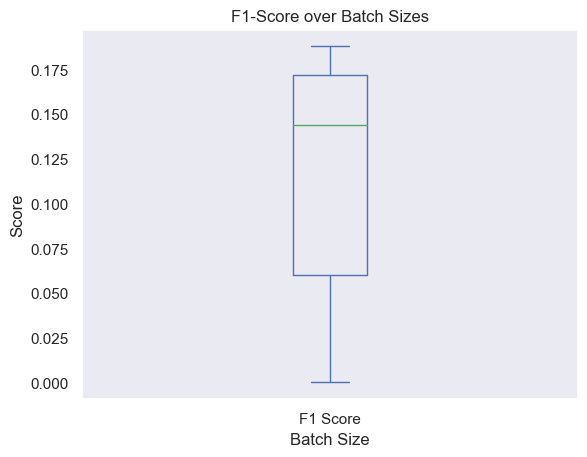

In [6]:
# NOTE: I re-used the following code for box plot generation for all of the params

# Read and clean the data
with open("results_basic_CNN.txt", "r") as f:
    data = [line.strip().split("\n")[0] for line in f]
    data = [eval(d) for d in data]
    print(data)

batch_size = [i[0]['batch_size'] for i in data]
f1_score = [i[1][1] for i in data]
data_plt_1 = [(batch_size[i], f1_score[i]) for i in range(len(batch_size))]

# Convert data to dataframe
df = pd.DataFrame(data_plt_1, columns=["Batch Size", "F1 Score"])

# Create box plot
fig, ax = plt.subplots()
df.plot(x="Batch Size", y="F1 Score", kind="box", ax=ax, grid=False)
ax.set_xlabel("Batch Size")
ax.set_ylabel("Score")
ax.set_title("F1-Score over Batch Sizes")
plt.show()


C:\Users\cwgia\AppData\Local\Temp\ipykernel_13656\637965405.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


[Text(0.5, 0, 'num_units'),
 Text(1.5, 0, 'filters'),
 Text(2.5, 0, 'dropout_rate'),
 Text(3.5, 0, 'n_epochs'),
 Text(4.5, 0, 'batch_size'),
 Text(5.5, 0, 'class_weight_binary'),
 Text(6.5, 0, 'pool_size'),
 Text(7.5, 0, 'n_augm'),
 Text(8.5, 0, 'f1_score')]

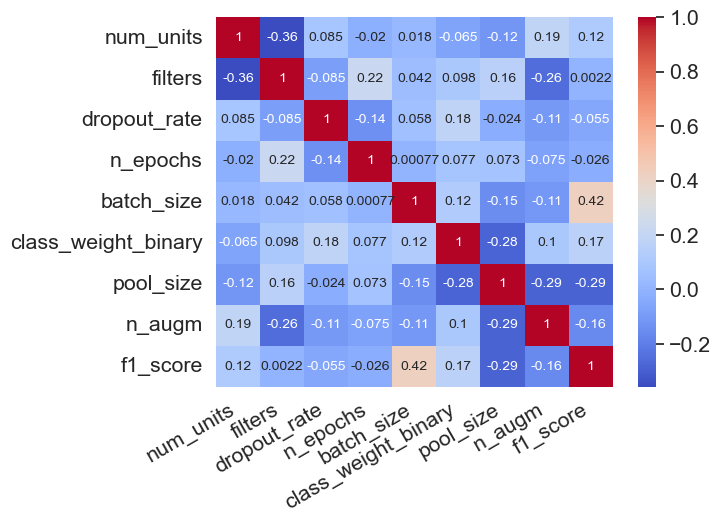

In [7]:
# Correlation matrix on a heatmap 

sns.set(font_scale=1.4)

# Read and clean the data
with open('results_basic_CNN.txt', 'r') as f:
    data = f.readlines()

data = [ast.literal_eval(x.strip()) for x in data]
tmp = [i[1][1] for i in data ]
for idx, val in enumerate(tmp):
    data[idx][0]['f1_score'] = val
    data[idx] = data[idx][0]

# Create a dataframe
df = pd.DataFrame(data)
f1_score = df['f1_score']

# Generate the correlation matrix
corr_matrix = df.corr()

# heatmap
ax = sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={'fontsize': 10})
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

